# Black Scholes Equation
$$\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + rS \frac{\partial V}{\partial S} - rV = 0$$

s.t. $V(S, 1) = \max(S-K, 0)$

We assume $S\in[0,1], T\in[0,1]$ ($T$ is normalized)

The constants are set to be $\sigma=0.1$, $r=0.05$, $K=0.5$

In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from deep_macrofin import PDEModel
from deep_macrofin import ActivationType, OptimizerType, Comparator, set_seeds, plot_loss_df

In [2]:
set_seeds(0)
pde = PDEModel("black_scholes", config={"num_epochs": 2000, "optimizer_type": OptimizerType.Adam})
pde.set_state(["S", "t"], {"S": [0., 1.], "t": [0., 1.]})
pde.add_endog("V")
pde.add_endog_equation(r"$\frac{\partial V}{\partial t} + \frac{1}{2} * 0.01 * S^2 * \frac{\partial^2 V}{\partial S^2} + 0.05 * S * \frac{\partial V}{\partial S} - 0.05 * V = 0$")

maturity_sv = torch.ones((100, 2))
maturity_sv[:, 0] = torch.Tensor(np.linspace(0, 1, 100))
maturity_prices = torch.where(maturity_sv[:, 0:1] > 0.5, maturity_sv[:, 0:1] - 0.5, 0)

pde.add_endog_condition("V", 
                        "V(SV)", {"SV": maturity_sv},
                        Comparator.EQ,
                        "maturity_prices", {"maturity_prices": maturity_prices},
                        label="bc1")

print(pde)
if not os.path.exists("./models/black_scholes/model.pt"):
    pde.train_model("./models/black_scholes", "model.pt", True)
    pde.load_model(torch.load("./models/black_scholes/model_best.pt"))
    pde.eval_model(True)
else:
    pde.load_model(torch.load("./models/black_scholes/model_best.pt"))
    pde.eval_model(True)

=========================Summary of Model black_scholes=========================
Config: {
 "batch_size": 100,
 "num_epochs": 2000,
 "lr": 0.001,
 "loss_log_interval": 100,
 "optimizer_type": "Adam"
}
Latex Variable Mapping:
{}
User Defined Parameters:
{}

================================State Variables=================================
S: [0.0, 1.0]
t: [0.0, 1.0]

=====================================Agents=====================================

================================Agent Conditions================================

==============================Endogenous Variables==============================
Endogenous Variable Name: V
EndogVar(
  (model): Sequential(
    (linear_0): Linear(in_features=2, out_features=30, bias=True)
    (activation_0): Tanh()
    (linear_1): Linear(in_features=30, out_features=30, bias=True)
    (activation_1): Tanh()
    (linear_2): Linear(in_features=30, out_features=30, bias=True)
    (activation_2): Tanh()
    (linear_3): Linear(in_features=30, out_fea

Total loss: 0.0000: 100%|██████████| 2000/2000 [00:21<00:00, 91.13it/s] 

training finished, total time :: 21.959071159362793
Best model saved to ./models/black_scholes/model_best.pt if valid
Model saved to ./models/black_scholes/model.pt
Model loaded
===================================Evaluating===================================
loss :: endogeq_1: 0.0000,
endogvar_V_cond_bc1: 0.0000,
total_loss: 0.0000


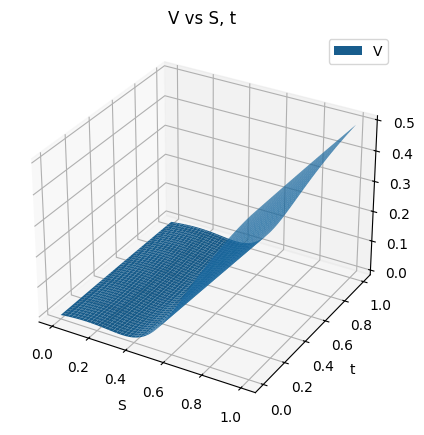

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw={"projection": "3d"})
pde.endog_vars["V"].plot("V", {"S": [0., 1.], "t": [0., 1.]}, ax=ax)
plt.subplots_adjust()
plt.show()

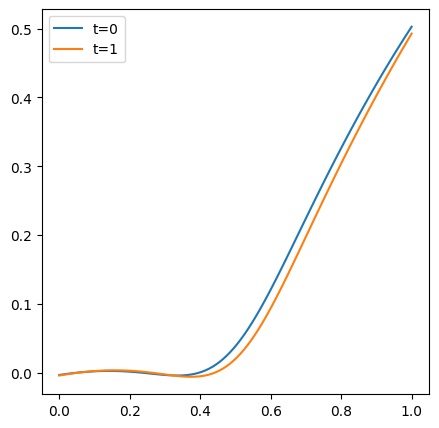

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
s_dim = np.linspace(0, 1, 100)
zero_t = torch.zeros((100, 2))
zero_t[:, 0] = torch.Tensor(s_dim)
V_zero_t = pde.endog_vars["V"].forward(zero_t).detach().cpu().numpy()

one_t = torch.ones((100, 2))
one_t[:, 0] = torch.Tensor(s_dim)
V_one_t = pde.endog_vars["V"].forward(one_t).detach().cpu().numpy()
ax.plot(s_dim, V_zero_t, label="t=0")
ax.plot(s_dim, V_one_t, label="t=1")
ax.legend()
plt.subplots_adjust()
plt.show()

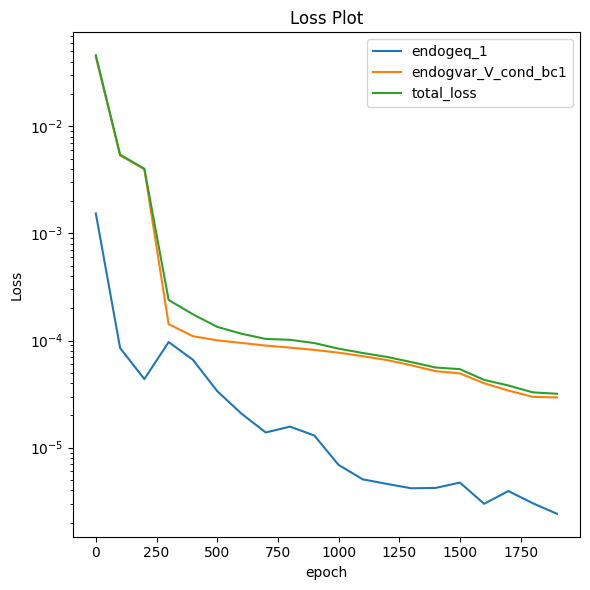

In [4]:
plot_loss_df(fn="./models/black_scholes/model_loss.csv", loss_plot_fn="./models/black_scholes/model_loss.png")